# Deloitte March Data Crunch Madness Competition
### Team: Bracket Busters

In [1]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from math import sin, cos, sqrt, atan2, radians
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (auc, classification_report, roc_auc_score, accuracy_score,
                             f1_score, log_loss, roc_curve, confusion_matrix, precision_score, recall_score)
import statsmodels.formula.api as smf
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV

In [2]:
#ncaa_data = pd.read_csv('allseasons.csv').query("season<2021")
ncaa_data = pd.read_csv('allseasons.csv').query("2009<season<2020")

In [3]:
ncaa_data

,team1_id,team1_score,team2_id,team2_score,WLoc,num_ot,team1_position,team2_position,team1_seed,team2_seed,...,team2_3PAr,team2_TS%,team2_TRB%,team2_AST%,team2_STL%,team2_BLK%,team2_eFG%,team2_TOV%,team2_ORB%,team2_FT/FGA
0,1192,82,1341,76,N,0,X16a,X16b,16,16,...,34.1,53.0,46.7,49.3,12.2,4.6,49.3,15.2,29.8,28.9
1,1125,81,1396,70,N,0,W11a,W11b,11,11,...,37.4,53.4,48.2,54.5,12.0,6.2,49.9,13.8,26.1,23.6
2,1295,78,1300,74,N,0,W16a,W16b,16,16,...,36.1,54.5,54.8,60.2,8.9,7.5,51.2,18.8,35.1,23.9
3,1113,74,1385,65,N,0,X11a,X11b,11,11,...,38.5,54.8,45.8,50.0,12.1,9.8,51.8,13.0,21.4,21.2
4,1278,86,1257,76,N,0,W10,W07,10,7,...,43.7,55.3,52.4,53.6,6.3,7.9,50.9,15.2,29.0,27.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1174,1260,78,1243,62,N,0,Y11,Y09,11,9,...,36.8,56.0,47.4,54.4,11.9,9.3,52.5,15.3,25.8,24.8
1175,1276,58,1199,54,N,0,Z03,Z09,3,9,...,36.8,56.2,51.8,52.6,9.4,14.0,53.2,15.4,32.0,25.6
1176,1437,95,1242,79,N,0,W01,X01,1,1,...,41.2,59.4,50.3,55.7,9.2,10.9,57.5,14.6,29.3,19.1
1177,1276,69,1260,57,N,0,Z03,Y11,3,11,...,35.7,60.2,51.3,59.7,9.6,6.8,57.7,17.3,22.4,23.1


## Pythag

In [4]:
## creating KenPom's Pythag variable
ncaa_data['exp_win1'] = (ncaa_data['team1_adjoe']**11.5)/ ((ncaa_data['team1_adjde']**11.5)+(ncaa_data['team1_adjoe']**11.5))
ncaa_data['exp_win2'] = (ncaa_data['team2_adjoe']**11.5)/ ((ncaa_data['team2_adjde']**11.5)+(ncaa_data['team2_adjoe']**11.5))

## Variables

### Log Odds

In [5]:
## creating a log odds variable that is a teams expected winning percentage when playing another team
ncaa_data['team1_log5'] = (ncaa_data['exp_win1'] - (ncaa_data['exp_win1']*ncaa_data['exp_win2']))/ (ncaa_data['exp_win1']+ncaa_data['exp_win2']-(2*ncaa_data['exp_win1']*ncaa_data['exp_win2']))

### Seed Difference

In [6]:
## calculates the seed difference between each winning and losing team
ncaa_data['seed_diff'] = ncaa_data['team1_seed'] - ncaa_data['team2_seed']

### Distance

In [7]:
## Creating a distance function to determine the distance each team traveled for their matchups
def distance(lat1, lon1, lat2, lon2):

    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    
    return distance

In [8]:
## calculating distance traveled for each team
ncaa_data['dist1'] = ncaa_data.apply(lambda row: distance(row['host_lat'], row['host_long'], row['team1_lat'], row['team1_long']), axis=1)
ncaa_data['dist2'] = ncaa_data.apply(lambda row: distance(row['host_lat'], row['host_long'], row['team2_lat'], row['team2_long']), axis=1)

In [9]:
## calculating difference in travel distance between each team
ncaa_data['diff_dist'] = ncaa_data['dist1'] - ncaa_data['dist2']

### SRS

In [10]:
## calculating the difference in SRS rating between teams
## SRS takes into account strength of schedule and average point differential
## strong indicator of past champions success
ncaa_data['srs_diff'] = ncaa_data['team1_SRS'] - ncaa_data['team2_SRS']

### Turnover %

In [11]:
## Calculates difference in teams turnover differential
ncaa_data['TOV_diff'] =  ncaa_data['team2_TOV%']- ncaa_data['team1_TOV%']

### True Shooting %

In [12]:
ncaa_data['TS_diff'] = ncaa_data['team1_TS%'] - ncaa_data['team2_TS%']

### True Rebounding %

In [13]:
ncaa_data['TRB_diff'] = ncaa_data['team1_TRB%'] - ncaa_data['team2_TRB%']

### Effective Field Goal %

In [14]:
ncaa_data['eFG_diff'] = ncaa_data['team1_eFG%'] - ncaa_data['team2_eFG%']

### Adjusted Tempo

In [15]:
## Calculates the difference in the teams adjusted tempo
ncaa_data['adjtempo_diff'] = ncaa_data['team1_adjtempo'] - ncaa_data['team2_adjtempo']

### Net Rating

In [16]:
## Calculates the difference in a teams adjusted offense minus its adjusted defense subtracted against their oppenents
## Strong indicator of a teams success
ncaa_data['net_rating_diff'] = (ncaa_data['team1_adjoe'] - ncaa_data['team1_adjde']) - (ncaa_data['team2_adjoe'] - ncaa_data['team2_adjde'])

### Ast/Stl/Block Diff

In [17]:
ncaa_data['ast_stl_block_diff'] = (ncaa_data['team1_arate'] + ncaa_data['team1_stlrate'] + ncaa_data['team1_blockpct']) - (ncaa_data['team2_arate'] + ncaa_data['team2_stlrate'] + ncaa_data['team2_blockpct'])

### Win Tempo Diff

In [18]:
ncaa_data['win_tempo_diff'] = (((ncaa_data['team1_adjoe'] - 100) -(100 - ncaa_data['team2_adjde'])+100)/100*((ncaa_data['team1_adjtempo'] + ncaa_data['team2_adjtempo'])/2)) - (((ncaa_data['team2_adjoe'] - 100) - (100 - ncaa_data['team1_adjde'])+100)/100*((ncaa_data['team1_adjtempo']+ncaa_data['team2_adjtempo'])/2))

## Analyzing Dataset

In [19]:
ncaa_data[['season','team1_teamname','team2_teamname','seed_diff','team1_log5','win_tempo_diff','srs_diff','net_rating_diff','ast_stl_block_diff','eFG_diff','TS_diff','TRB_diff','TOV_diff']]

,season,team1_teamname,team2_teamname,seed_diff,team1_log5,win_tempo_diff,srs_diff,net_rating_diff,ast_stl_block_diff,eFG_diff,TS_diff,TRB_diff,TOV_diff
0,2019,F Dickinson,Prairie View,0,0.506403,0.034468,1.20,0.0500,9.284429,5.1,4.6,2.6,-2.1
1,2019,Belmont,Temple,0,0.585922,2.546911,0.95,3.6380,6.658113,8.1,6.9,4.0,0.1
2,2019,N Dakota St,NC Central,0,0.730051,5.665442,7.52,8.7079,-14.416704,2.8,3.1,-6.1,4.6
3,2019,Arizona St,St John's,0,0.570190,1.738213,2.40,2.4636,-2.996976,-1.2,-0.5,6.8,-3.1
4,2019,Minnesota,Louisville,3,0.322116,-4.401477,-4.76,-6.5352,9.684422,-2.7,-3.2,-1.2,0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1174,2018,Loyola-Chicago,Kansas St,2,0.720863,5.297400,-2.48,8.1000,-0.028481,5.2,4.2,3.9,-2.0
1175,2018,Michigan,Florida St,-6,0.648177,3.604000,3.25,5.3000,-2.334396,1.3,0.2,-1.5,3.0
1176,2018,Villanova,Kansas,0,0.695616,5.673050,5.25,8.3000,-3.481968,2.0,2.9,2.1,1.3
1177,2018,Michigan,Loyola-Chicago,-8,0.486853,-0.064850,8.66,-0.1000,-3.943788,-3.2,-3.8,-1.0,4.9


In [20]:
ncaa_data.fillna(0, inplace=True)

In [21]:
ncaa_data.describe()

,team1_id,team1_score,team2_id,team2_score,num_ot,team1_seed,team2_seed,strongseed,weakseed,season,...,diff_dist,srs_diff,TOV_diff,TS_diff,TRB_diff,eFG_diff,adjtempo_diff,net_rating_diff,ast_stl_block_diff,win_tempo_diff
count,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000,667.00000,667.000000,...,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000
mean,1290.592204,74.797601,1295.725637,63.458771,0.056972,5.496252,8.892054,4.167916,10.22039,2014.520240,...,-194.908693,5.757616,0.495352,1.084258,0.605697,1.111694,-0.264110,5.636244,1.310103,3.776440
std,102.136774,10.357258,103.720235,10.110621,0.262338,4.179303,4.628257,3.364091,3.87310,2.864947,...,1139.123952,9.474601,2.142020,6.621598,3.445661,6.494612,3.994642,10.539197,8.807528,7.039637
min,1104.000000,47.000000,1101.000000,34.000000,0.000000,1.000000,1.000000,1.000000,1.00000,2010.000000,...,-3581.990105,-24.220000,-5.500000,-9.100000,-10.400000,-10.000000,-11.495500,-27.467200,-22.985700,-18.408009
25%,1211.000000,68.000000,1211.000000,57.000000,0.000000,2.000000,5.000000,2.000000,8.00000,2012.000000,...,-803.542997,-0.510000,-1.000000,-1.850000,-1.600000,-1.900000,-2.765250,-1.177850,-4.771012,-0.812265
50%,1276.000000,75.000000,1295.000000,63.000000,0.000000,4.000000,9.000000,3.000000,11.00000,2015.000000,...,-176.576121,4.050000,0.600000,0.600000,0.600000,0.700000,-0.122500,4.494200,1.207400,3.016467
75%,1388.000000,81.000000,1388.500000,70.000000,0.000000,8.000000,13.000000,6.000000,13.00000,2017.000000,...,407.881326,10.910000,2.000000,3.000000,2.800000,3.450000,2.261950,11.674100,7.656200,7.786729
max,1463.000000,105.000000,1463.000000,96.000000,2.000000,16.000000,16.000000,16.000000,16.00000,2019.000000,...,3917.144567,36.970000,9.500000,61.600000,11.200000,58.900000,9.945200,40.683600,28.702300,27.051705


In [22]:
## Making sure there are no na values in dataframe
ncaa_data.isna().sum().sort_values(ascending=True)

team1_id                         0
team2_adjtempo                   0
team2_oe                         0
team2_adjoe                      0
team2_de                         0
                                ..
team2_pt_coach_season_wins       0
team2_pt_coach_season_losses     0
team1_ap_final                   0
team2_pt_career_school_losses    0
win_tempo_diff                   0
Length: 154, dtype: int64

In [23]:
new_data_ncaa = ncaa_data[['exp_win1','team1_log5','seed_diff','srs_diff','net_rating_diff','win_tempo_diff','ast_stl_block_diff','eFG_diff','TS_diff','TRB_diff','TOV_diff']].copy()

## Correlation of Variables

In [24]:
new_corr = new_data_ncaa.corr()
new_corr

,exp_win1,team1_log5,seed_diff,srs_diff,net_rating_diff,win_tempo_diff,ast_stl_block_diff,eFG_diff,TS_diff,TRB_diff,TOV_diff
exp_win1,1.000000,0.534899,-0.460650,0.443351,0.516340,0.515734,0.125949,0.042786,0.023442,0.245870,0.209733
team1_log5,0.534899,1.000000,-0.870615,0.898239,0.967015,0.965802,0.302732,0.183078,0.156061,0.439391,0.341225
seed_diff,-0.460650,-0.870615,1.000000,-0.881950,-0.863320,-0.863297,-0.290679,-0.130995,-0.110348,-0.333836,-0.310186
srs_diff,0.443351,0.898239,-0.881950,1.000000,0.933103,0.934304,0.327975,0.137007,0.111126,0.396936,0.365132
net_rating_diff,0.516340,0.967015,-0.863320,0.933103,1.000000,0.999231,0.309555,0.225111,0.197097,0.436541,0.374913
win_tempo_diff,0.515734,0.965802,-0.863297,0.934304,0.999231,1.000000,0.312223,0.224436,0.196007,0.439584,0.369905
ast_stl_block_diff,0.125949,0.302732,-0.290679,0.327975,0.309555,0.312223,1.000000,0.016345,-0.012544,0.167422,-0.144528
eFG_diff,0.042786,0.183078,-0.130995,0.137007,0.225111,0.224436,0.016345,1.000000,0.988879,0.052998,0.053210
TS_diff,0.023442,0.156061,-0.110348,0.111126,0.197097,0.196007,-0.012544,0.988879,1.000000,0.040043,0.037389
TRB_diff,0.245870,0.439391,-0.333836,0.396936,0.436541,0.439584,0.167422,0.052998,0.040043,1.000000,-0.150259


In [25]:
new2data = ncaa_data.copy()

In [26]:
corr = new2data.corr()
corr

,team1_id,team1_score,team2_id,team2_score,num_ot,team1_seed,team2_seed,strongseed,weakseed,season,...,diff_dist,srs_diff,TOV_diff,TS_diff,TRB_diff,eFG_diff,adjtempo_diff,net_rating_diff,ast_stl_block_diff,win_tempo_diff
team1_id,1.000000,0.004949,-0.058657,-0.010808,-0.000028,0.041250,-0.013377,0.016320,0.014351,0.084300,...,0.008927,-0.015250,0.102385,-0.119415,-0.014461,-0.115367,-0.153142,-0.018362,0.064420,-0.021470
team1_score,0.004949,1.000000,-0.108337,0.645690,0.131903,-0.159564,0.107263,-0.122099,0.062050,0.168262,...,-0.064671,0.229837,0.030677,-0.018444,0.205107,0.000049,-0.070241,0.218886,0.111987,0.228002
team2_id,-0.058657,-0.108337,1.000000,-0.045837,0.031533,0.065754,-0.020152,0.043763,0.008860,-0.017103,...,-0.043062,-0.058682,-0.076936,0.134550,-0.032193,0.140935,0.058380,-0.054611,-0.068744,-0.053079
team2_score,-0.010808,0.645690,-0.045837,1.000000,0.277705,0.043250,-0.148273,0.006870,-0.136481,0.139584,...,0.029548,-0.175839,-0.131997,-0.046627,0.017130,-0.042229,-0.049488,-0.138692,-0.002957,-0.131299
num_ot,-0.000028,0.131903,0.031533,0.277705,1.000000,0.024846,-0.071600,0.026574,-0.081831,-0.049483,...,-0.009490,-0.097633,0.012763,-0.002249,-0.060989,-0.003300,-0.020537,-0.062059,-0.003048,-0.061905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eFG_diff,-0.115367,0.000049,0.140935,-0.042229,-0.003300,-0.066994,0.127131,-0.018563,0.095750,-0.024060,...,-0.127798,0.137007,0.053210,0.988879,0.052998,1.000000,-0.018278,0.225111,0.016345,0.224436
adjtempo_diff,-0.153142,-0.070241,0.058380,-0.049488,-0.020537,-0.020470,-0.029152,-0.065996,0.000399,-0.033482,...,0.024991,0.023810,-0.067852,-0.025234,-0.050789,-0.018278,1.000000,-0.035706,0.028332,-0.030341
net_rating_diff,-0.018362,0.218886,-0.054611,-0.138692,-0.062059,-0.626405,0.670903,-0.296535,0.383348,0.066248,...,-0.225810,0.933103,0.374913,0.197097,0.436541,0.225111,-0.035706,1.000000,0.309555,0.999231
ast_stl_block_diff,0.064420,0.111987,-0.068744,-0.002957,-0.003048,-0.170452,0.262426,-0.060471,0.182187,0.077458,...,-0.047007,0.327975,-0.144528,-0.012544,0.167422,0.016345,0.028332,0.309555,1.000000,0.312223


<IPython.core.display.Javascript object>

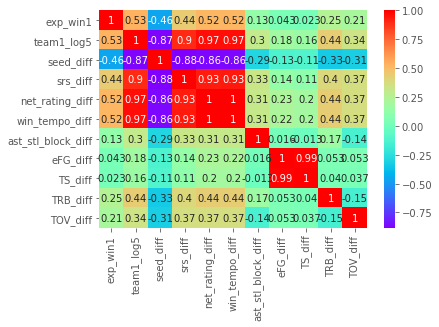

In [27]:
sns.heatmap(data=new_corr, annot = True, cmap = "rainbow");

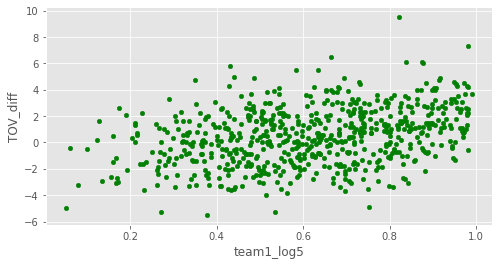

In [28]:
ncaa_data.plot(x="team1_log5", y = "TOV_diff", kind="scatter", figsize=(8,4), color="green" );

## First Logistic Regression Model

### Split Data

In [29]:
ncaa_data.dropna(subset=['team1_log5'], inplace=True)

In [30]:
ncaa_data['team1_win'] = (ncaa_data['team1_score']>ncaa_data['team2_score']).astype(int)

In [31]:
## Training data, creating sample training set
training_columns = ['game_id','season','team1_win','exp_win1','exp_win2','team2_score',
                                    'team1_score','team1_id','team2_id','team1_log5','seed_diff','TS_diff','eFG_diff','adjtempo_diff','TRB_diff','TOV_diff','srs_diff','net_rating_diff']
ncaa_data_1 = ncaa_data.sample(frac=.5, random_state=15)[training_columns]
ncaa_data_2 = ncaa_data[~ncaa_data.index.isin(ncaa_data_1.index)][training_columns].reset_index(drop=True)
ncaa_data_1 = ncaa_data_1.reset_index(drop=True)

In [32]:
ncaa_data_2['team1_win'] = 0
ncaa_data_2['team1_log5'] = 1-ncaa_data_2['team1_log5']
ncaa_data_2['game_id'] = (ncaa_data_2['game_id'].str.split('-', expand=True)[0] 
                           + '-' + ncaa_data_2['game_id'].str.split('-', expand=True)[2] 
                           + '-' + ncaa_data_2['game_id'].str.split('-', expand=True)[1]
                           ) 
ncaa_data_2['seed_diff'] = ncaa_data_2['seed_diff']*-1
ncaa_data_2.columns = ['game_id','season','team1_win','exp_win1','exp_win2','team2_score',
                                    'team1_score','team1_id','team2_id','team1_log5','seed_diff','TS_diff','eFG_diff','adjtempo_diff','TRB_diff','TOV_diff','srs_diff','net_rating_diff']

In [33]:
ncaa_train = pd.concat([ncaa_data_2, ncaa_data_1]).reset_index(drop=True)

In [34]:
train, test = train_test_split(ncaa_train, train_size=.7)

In [35]:
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [36]:
train

,game_id,season,team1_win,exp_win1,exp_win2,team2_score,team1_score,team1_id,team2_id,team1_log5,seed_diff,TS_diff,eFG_diff,adjtempo_diff,TRB_diff,TOV_diff,srs_diff,net_rating_diff
0,2015-1209-1124,2015,1,0.734433,0.903814,56,57,1209,1124,0.227390,11,3.3,3.0,1.1199,-7.0,2.2,-12.38,-11.1523
1,2011-1163-1361,2011,1,0.902118,0.935938,67,74,1163,1361,0.386814,1,-1.7,-3.3,2.0952,-2.0,-0.1,-0.01,-3.2645
2,2018-1113-1393,2018,0,0.631139,0.758328,56,60,1393,1113,0.647126,0,-5.8,-6.9,-8.2000,3.6,-3.2,-1.48,-6.1000
3,2019-1125-1268,2019,0,0.901775,0.800207,77,79,1268,1125,0.303748,5,-5.3,-6.6,-5.4959,3.8,-2.8,6.89,6.9140
4,2014-1217-1153,2014,1,0.840196,0.870061,57,61,1217,1153,0.439841,7,4.5,4.2,1.9359,-1.1,-0.6,-4.47,-1.4935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461,2018-1211-1326,2018,1,0.935503,0.813854,84,90,1211,1326,0.768386,-1,2.3,2.9,2.6000,2.4,1.0,0.77,11.5000
462,2017-1376-1181,2017,1,0.882852,0.935206,81,88,1376,1181,0.343027,5,-7.0,-7.1,0.2280,-1.1,-1.3,-4.04,-8.0796
463,2016-1455-1112,2016,1,0.919546,0.916016,55,65,1455,1112,0.511695,5,-4.4,-4.6,-3.1369,-3.4,3.0,-1.40,-0.6832
464,2019-1199-1293,2019,1,0.928100,0.810028,62,90,1199,1293,0.751696,-8,-4.1,-5.2,-0.7665,1.1,-1.5,9.03,9.2708


### Initial Check

In [37]:
train.groupby('team1_win')['team1_log5'].mean()

team1_win
0    0.389990
1    0.615939
Name: team1_log5, dtype: float64

In [38]:
train.groupby('team1_win')['seed_diff'].mean()

team1_win
0    3.195833
1   -3.570796
Name: seed_diff, dtype: float64

In [39]:
train.groupby('team1_win')['net_rating_diff'].mean()

team1_win
0    5.461257
1    5.741332
Name: net_rating_diff, dtype: float64

In [40]:
train.groupby('team1_win')['srs_diff'].mean()

team1_win
0    5.559625
1    5.792345
Name: srs_diff, dtype: float64

### Training Logistic Regression Model

In [41]:
logit = LogisticRegression()
logit.fit(train[['team1_log5','seed_diff','TS_diff','eFG_diff','adjtempo_diff','TRB_diff','TOV_diff','srs_diff','net_rating_diff']], train['team1_win'])

LogisticRegression()

In [42]:
smlogit = smf.logit("team1_win ~ team1_log5 + seed_diff + TS_diff + eFG_diff + adjtempo_diff + TOV_diff + TRB_diff + srs_diff + net_rating_diff", train).fit()
smlogit.summary()

Optimization terminated successfully.
         Current function value: 0.557286
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              team1_win   No. Observations:                  466
Model:                          Logit   Df Residuals:                      456
Method:                           MLE   Df Model:                            9
Date:                Mon, 06 Jun 2022   Pseudo R-squ.:                  0.1955
Time:                        19:29:19   Log-Likelihood:                -259.70
converged:                       True   LL-Null:                       -322.80
Covariance Type:            nonrobust   LLR p-value:                 7.153e-23
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -1.7899      0.519     -3.450      0.001      -2.807      -0.773
team1_log5          3.3510      1.000      3.352      0.001       1.392       5.310
seed_diff          -0.0628      0.032     -1.938      0.053      -0.126       0.001
TS_diff            -0.0948      0.115     -0.825      0.410      -0.320       0.131
eFG_diff            0.0701      0.116      0.603      0.547      -0.158       0.298
adjtempo_diff      -0.0186      0.028     -0.677      0.498      -0.073       0.035
TOV_diff           -0.0663      0.060     -1.114      0.265      -0.183       0.050
TRB_diff           -0.0887      0.040     -2.230      0.026      -0.167      -0.011
srs_diff           -0.0239      0.033     -0.729      0.466      -0.088       0.040
net_rating_diff     0.0529      0.031      1.684      0.092      -0.009       0.115
===================================================================================
"""

In [43]:
test['prob'] = logit.predict_proba(test[['team1_log5','seed_diff','TS_diff','eFG_diff','adjtempo_diff','TRB_diff','TOV_diff','srs_diff','net_rating_diff']])[:,1]
test['prediction'] = logit.predict(test[['team1_log5','seed_diff','TS_diff','eFG_diff','adjtempo_diff','TRB_diff','TOV_diff','srs_diff','net_rating_diff']])

In [44]:
accuracy_score(test['team1_win'], test['prediction'],)

0.6766169154228856

In [45]:
precision_score(test['team1_win'], test['prediction'])

0.7216494845360825

In [46]:
recall_score(test['team1_win'], test['prediction'])

0.6481481481481481

In [47]:
f1_score(test['team1_win'], test['prediction'])

0.6829268292682927

In [48]:
log_loss(test['team1_win'].values, test['prob'].values)

0.5642368948103397

In [49]:
def plot_roc(fpr, tpr, roc_auc):
    """Plots the ROC curve for the win probability model along with
    the AUC.
    """
    fig, ax = plt.subplots()
    ax.set(title='Receiver Operating Characteristic',
           xlim=[0, 1], ylim=[0, 1], xlabel='False Positive Rate',
           ylabel='True Positive Rate')
    ax.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.legend(loc='lower right')

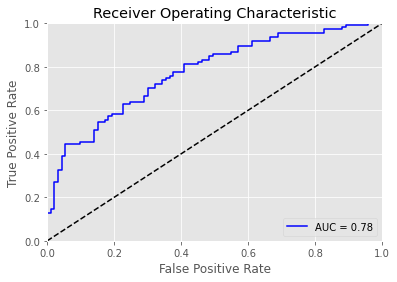

In [50]:
fpr, tpr, thresholds = roc_curve(test['team1_win'].values, test['prob'].values)
roc_auc = auc(fpr, tpr)
plot_roc(fpr, tpr, roc_auc)

In [51]:
roc_auc_score(test['team1_win'].values, test['prob'].values)

0.7755874153723616

## Second Logistic Regression Model

### Variables used: Log5, seed_diff, win_tempo_diff, TRB_diff, TOV_diff, srs_diff, net_rating_diff

In [52]:
ncaa_data.dropna(subset=['team1_log5'], inplace=True)

In [53]:
ncaa_data['team1_win'] = (ncaa_data['team1_score']>ncaa_data['team2_score']).astype(int)

In [54]:
training_columns = ['game_id','season','team1_win','exp_win1','exp_win2','team2_score',
                                    'team1_score','team1_id','team2_id','team1_log5','seed_diff','win_tempo_diff','TRB_diff','srs_diff','net_rating_diff']
ncaa_data_1 = ncaa_data.sample(frac=.5, random_state=15)[training_columns]
ncaa_data_2 = ncaa_data[~ncaa_data.index.isin(ncaa_data_1.index)][training_columns].reset_index(drop=True)
ncaa_data_1 = ncaa_data_1.reset_index(drop=True)

In [55]:
ncaa_data_2['team1_win'] = 0
ncaa_data_2['team1_log5'] = 1-ncaa_data_2['team1_log5']
ncaa_data_2['game_id'] = (ncaa_data_2['game_id'].str.split('-', expand=True)[0] 
                           + '-' + ncaa_data_2['game_id'].str.split('-', expand=True)[2] 
                           + '-' + ncaa_data_2['game_id'].str.split('-', expand=True)[1]
                           ) 
ncaa_data_2['seed_diff'] = ncaa_data_2['seed_diff']*-1
ncaa_data_2.columns = ['game_id','season','team1_win','exp_win1','exp_win2','team2_score',
                                    'team1_score','team1_id','team2_id','team1_log5','seed_diff','win_tempo_diff','TRB_diff','srs_diff','net_rating_diff']

In [56]:
ncaa_train = pd.concat([ncaa_data_2, ncaa_data_1]).reset_index(drop=True)

In [57]:
train, test = train_test_split(ncaa_train, train_size=.75)

In [58]:
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [59]:
train

,game_id,season,team1_win,exp_win1,exp_win2,team2_score,team1_score,team1_id,team2_id,team1_log5,seed_diff,win_tempo_diff,TRB_diff,srs_diff,net_rating_diff
0,2011-1452-1155,2011,1,0.879452,0.867362,76,84,1452,1155,0.527327,-7,1.007318,1.2,2.39,1.5667
1,2016-1451-1462,2016,0,0.915055,0.577263,53,71,1462,1451,0.112503,13,13.388884,2.3,18.40,18.9559
2,2015-1323-1246,2015,0,0.978741,0.912696,66,68,1246,1323,0.185055,2,7.236343,5.1,9.49,11.3448
3,2013-1326-1235,2013,1,0.929888,0.841339,75,78,1326,1235,0.714380,-8,4.599045,-0.7,5.69,6.8830
4,2014-1142-1411,2014,1,0.469725,0.347385,69,81,1142,1411,0.624643,0,3.117385,-3.4,7.07,4.8888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2013-1166-1181,2013,0,0.929207,0.889406,50,66,1181,1166,0.379922,5,2.783372,-4.3,5.03,4.1883
496,2017-1266-1376,2017,0,0.882852,0.858997,73,93,1376,1266,0.447016,3,-0.407784,1.2,2.26,-0.5918
497,2011-1246-1163,2011,0,0.902118,0.926438,55,56,1163,1246,0.577432,1,-1.990354,0.4,-2.35,-2.9921
498,2010-1424-1320,2010,0,0.879777,0.838713,66,69,1320,1424,0.415412,-1,1.599663,0.0,0.00,2.5143


In [60]:
logit = LogisticRegression()
logit.fit(train[['team1_log5','seed_diff','win_tempo_diff','TRB_diff','srs_diff','net_rating_diff']], train['team1_win'])

LogisticRegression()

In [61]:
smlogit = smf.logit("team1_win ~ team1_log5 + seed_diff + win_tempo_diff + TRB_diff + srs_diff + net_rating_diff", train).fit()
smlogit.summary()

Optimization terminated successfully.
         Current function value: 0.546760
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              team1_win   No. Observations:                  500
Model:                          Logit   Df Residuals:                      493
Method:                           MLE   Df Model:                            6
Date:                Mon, 06 Jun 2022   Pseudo R-squ.:                  0.2110
Time:                        19:29:24   Log-Likelihood:                -273.38
converged:                       True   LL-Null:                       -346.47
Covariance Type:            nonrobust   LLR p-value:                 4.949e-29
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -1.8302      0.506     -3.616      0.000      -2.822      -0.838
team1_log5          3.5994      0.986      3.649      0.000       1.666       5.533
seed_diff          -0.0633      0.032     -1.962      0.050      -0.126   -6.09e-05
win_tempo_diff     -0.8782      0.518     -1.696      0.090      -1.893       0.136
TRB_diff           -0.0470      0.035     -1.334      0.182      -0.116       0.022
srs_diff            0.0024      0.033      0.073      0.941      -0.062       0.067
net_rating_diff     0.6053      0.344      1.761      0.078      -0.068       1.279
===================================================================================
"""

In [62]:
test['prob'] = logit.predict_proba(test[['team1_log5','seed_diff','win_tempo_diff','TRB_diff','srs_diff','net_rating_diff']])[:,1]
test['prediction'] = logit.predict(test[['team1_log5','seed_diff','win_tempo_diff','TRB_diff','srs_diff','net_rating_diff']])

In [63]:
accuracy_score(test['team1_win'], test['prediction'],)

0.6586826347305389

In [64]:
precision_score(test['team1_win'], test['prediction'])

0.627906976744186

In [65]:
recall_score(test['team1_win'], test['prediction'])

0.6835443037974683

In [66]:
f1_score(test['team1_win'], test['prediction'])

0.6545454545454547

In [67]:
log_loss(test['team1_win'].values, test['prob'].values)

0.5996949812556769

In [68]:
def plot_roc(fpr, tpr, roc_auc):
    """Plots the ROC curve for the win probability model along with
    the AUC.
    """
    fig, ax = plt.subplots()
    ax.set(title='Receiver Operating Characteristic',
           xlim=[0, 1], ylim=[0, 1], xlabel='False Positive Rate',
           ylabel='True Positive Rate')
    ax.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.legend(loc='lower right')

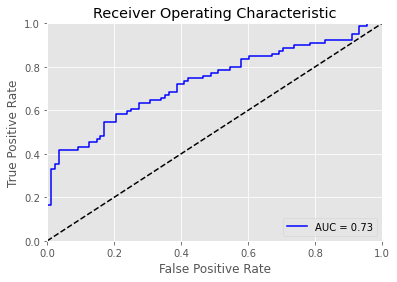

In [69]:
fpr, tpr, thresholds = roc_curve(test['team1_win'].values, test['prob'].values)
roc_auc = auc(fpr, tpr)
plot_roc(fpr, tpr, roc_auc)

In [70]:
roc_auc_score(test['team1_win'].values, test['prob'].values)

0.7315880322209435

## Random Forest Model

In [71]:
mm_data = new2data

In [72]:
mm_data.dropna(subset=['team1_log5'], inplace=True)

In [73]:
mm_data['team1_win'] = (mm_data['team1_score']>mm_data['team2_score']).astype(int)

In [74]:
training_columns = ['game_id','team1_win','team1_adjoe','team2_adjoe','team1_adjtempo','team2_adjtempo',
                                    'team2_adjde','team1_adjde','team1_fg2pct',
                    'team1_fg3pct','team1_ftpct','team2_fg2pct','team2_fg3pct','team2_ftpct','team1_TS%','team2_TS%',
                   'team1_blockpct','team2_blockpct','win_tempo_diff',
                   'team1_log5','diff_dist','seed_diff','net_rating_diff','srs_diff','TRB_diff', 'eFG_diff'
                   ,'adjtempo_diff','TOV_diff']
mm_data_1 = mm_data.sample(frac=.5, random_state=15)[training_columns]
mm_data_2 = mm_data[~mm_data.index.isin(mm_data_1.index)][training_columns].reset_index(drop=True)
mm_data_1 = mm_data_1.reset_index(drop=True)

In [75]:
mm_data_2['team1_win'] = 0
mm_data_2['win_tempo_diff'] = mm_data_2['win_tempo_diff']*-1
mm_data_2['net_rating_diff'] = mm_data_2['net_rating_diff']*-1
mm_data_2['srs_diff'] = mm_data_2['srs_diff']*-1
mm_data_2['TRB_diff'] = mm_data_2['TRB_diff']*-1
mm_data_2['diff_dist'] = mm_data_2['diff_dist']*-1
mm_data_2['TOV_diff'] = mm_data_2['TOV_diff']*-1
mm_data_2['eFG_diff'] = mm_data_2['eFG_diff']*-1
mm_data_2['adjtempo_diff'] = mm_data_2['adjtempo_diff']*-1
mm_data_2['team1_log5'] = 1-mm_data_2['team1_log5']
mm_data_2['game_id'] = (mm_data_2['game_id'].str.split('-', expand=True)[0] 
                           + '-' + mm_data_2['game_id'].str.split('-', expand=True)[2] 
                           + '-' + mm_data_2['game_id'].str.split('-', expand=True)[1]
                           ) 
mm_data_2['seed_diff'] = mm_data_2['seed_diff']*-1
mm_data_2.columns =['game_id','team1_win','team1_adjoe','team2_adjoe','team1_adjtempo','team2_adjtempo',
                                    'team2_adjde','team1_adjde','team1_fg2pct',
                    'team1_fg3pct','team1_ftpct','team2_fg2pct','team2_fg3pct','team2_ftpct','team1_TS%','team2_TS%',
                   'team1_blockpct','team2_blockpct','win_tempo_diff',
                   'team1_log5','diff_dist','seed_diff','net_rating_diff','srs_diff','TRB_diff',
                   'TOV_diff','eFG_diff','adjtempo_diff']

In [76]:
mm_train = pd.concat([mm_data_2, mm_data_1]).reset_index(drop=True)

In [77]:
## reset data to maybe change variables
data = mm_train
data = data.drop(columns=['game_id'])

In [78]:
## Use this line to change the variables of the random forest model
data = data[['team1_win','team1_adjoe','team2_adjoe','team1_adjtempo','team2_adjtempo',
                                    'team2_adjde','team1_adjde','team1_fg2pct',
                    'team1_fg3pct','team1_ftpct','team2_fg2pct','team2_fg3pct','team2_ftpct','team1_TS%','team2_TS%',
                   'team1_blockpct','team2_blockpct','win_tempo_diff',
                   'team1_log5','diff_dist','seed_diff','net_rating_diff','srs_diff','TRB_diff',
                   'TOV_diff','eFG_diff','adjtempo_diff']]

In [79]:
## Sets team1_win as first column, which makes it easier to set into array
data = data[ ['team1_win'] + [ col for col in data.columns if col != 'team1_win' ] ]

In [80]:
data.describe()

,team1_win,team1_adjoe,team2_adjoe,team1_adjtempo,team2_adjtempo,team2_adjde,team1_adjde,team1_fg2pct,team1_fg3pct,team1_ftpct,...,win_tempo_diff,team1_log5,diff_dist,seed_diff,net_rating_diff,srs_diff,TRB_diff,TOV_diff,eFG_diff,adjtempo_diff
count,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000,...,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000,667.000000
mean,0.500750,113.508182,110.349322,66.616774,66.880884,96.820227,94.342843,51.484568,36.245761,71.355084,...,0.189459,0.505348,4.949954,-0.301349,0.304964,0.292819,-0.076162,-0.539580,0.434664,-0.372775
std,0.500375,5.736558,5.816666,2.968515,3.028559,5.032049,4.449220,3.123882,2.711717,3.447040,...,7.987707,0.239202,1155.692553,7.443322,11.949748,11.085220,3.497741,6.189834,3.942677,3.130496
min,0.000000,90.158400,90.158400,57.615400,57.615400,85.314400,83.799400,43.683400,29.577500,60.719900,...,-27.051705,0.009786,-3581.990105,-15.000000,-40.683600,-36.970000,-9.800000,-58.900000,-9.000000,-11.240200
25%,0.000000,109.655950,106.734650,64.794700,64.881600,93.533300,90.880700,49.271800,34.264544,68.811195,...,-4.466078,0.326355,-611.120134,-6.500000,-6.751700,-5.570000,-2.300000,-1.900000,-2.218850,-2.278850
50%,1.000000,113.646000,110.323000,66.560100,66.924800,96.462100,94.200000,51.261200,36.257310,71.075400,...,0.155575,0.502939,-13.840606,0.000000,0.230800,0.000000,-0.100000,0.200000,0.362000,-0.300000
75%,1.000000,117.752000,114.100000,68.604400,68.896500,100.184000,97.300000,53.098750,38.061650,73.926750,...,4.610378,0.684610,623.368702,5.000000,7.004850,6.035000,2.200000,1.900000,3.066450,1.487150
max,1.000000,125.688800,125.688800,74.800000,76.323100,113.713000,110.550000,62.258314,43.281500,81.801100,...,25.364610,0.981828,3917.144567,15.000000,37.113800,33.880000,11.200000,10.000000,12.000000,9.945200


In [81]:
X = data
y = data['team1_win']
X = X.drop(columns=['team1_win'])

In [82]:
# Used to gather a list of important variables once random forest model is built
data_list = list(X.columns)

In [83]:
# Turns data into array, this can be skipped
X = data.iloc[:, 1:].values
y = data.iloc[:, 0].values

#### Testing/Training split, Getting data ready for modeling

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42)

In [85]:
## Normalizing Variables
X_train = preprocessing.normalize(X_train)
X_test = preprocessing.normalize(X_test)

In [86]:
## Scaling Variables
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#### Running the RF Model

In [87]:
rf = RandomForestClassifier(n_estimators=200, random_state=42, max_features = .25)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
predictions = rf.predict_proba(X_test)

In [88]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[ 97  47]
 [ 23 100]]
              precision    recall  f1-score   support

           0       0.81      0.67      0.73       144
           1       0.68      0.81      0.74       123

    accuracy                           0.74       267
   macro avg       0.74      0.74      0.74       267
weighted avg       0.75      0.74      0.74       267

0.7378277153558053


In [89]:
accuracy_RF2 = cross_val_score(rf,X,y,scoring = 'accuracy')
log_loss_RF2 = cross_val_score(rf,X,y,scoring = 'neg_log_loss')
print("Accuracy: ", (accuracy_RF2.mean(), accuracy_RF2.std() * 2))
print("Log Loss: ", (log_loss_RF2.mean(), log_loss_RF2.std() * 2))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Accuracy:  (0.871058242621479, 0.03723324799221105)
Log Loss:  (-0.3586879949293159, 0.053313915466478574)


In [90]:
scores = cross_val_score(rf, X_train, y_train.ravel(),cv=5, scoring = 'f1')
print ("Mean Validation F1 for Random Forest:","%0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

<IPython.core.display.Javascript object>

Mean Validation F1 for Random Forest: 0.72 (+/- 0.10)


In [91]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
data_importances = [(data, round(importance, 5)) for data, importance in zip(data_list, importances)]

# Sort the feature importances by most important first
data_importances = sorted(data_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in data_importances];

Variable: srs_diff             Importance: 0.12676
Variable: win_tempo_diff       Importance: 0.08735
Variable: TOV_diff             Importance: 0.08302
Variable: net_rating_diff      Importance: 0.07804
Variable: adjtempo_diff        Importance: 0.06589
Variable: seed_diff            Importance: 0.06413
Variable: team1_log5           Importance: 0.04741
Variable: eFG_diff             Importance: 0.04401
Variable: team2_blockpct       Importance: 0.03934
Variable: TRB_diff             Importance: 0.03674
Variable: team1_blockpct       Importance: 0.02993
Variable: diff_dist            Importance: 0.02791
Variable: team2_adjoe          Importance: 0.025
Variable: team2_fg3pct         Importance: 0.02131
Variable: team2_adjde          Importance: 0.02039
Variable: team2_TS%            Importance: 0.02018
Variable: team1_adjoe          Importance: 0.01999
Variable: team2_ftpct          Importance: 0.01957
Variable: team1_fg3pct         Importance: 0.0192
Variable: team1_adjde          Imp

#### Feature Selection (RFE)

In [92]:
rfe = RFE(estimator=rf, n_features_to_select=10, step=1)
rfe.fit(X, y)

RFE(estimator=RandomForestClassifier(max_features=0.25, n_estimators=200,
                                     random_state=42),
    n_features_to_select=10)

In [93]:
X_new_RFE = rfe.transform(X)

In [94]:
feature_names = np.array(data_list)
feature_names[rfe.get_support()]

array(['team1_adjoe', 'team2_adjoe', 'team2_adjde', 'team1_adjde',
       'win_tempo_diff', 'team1_log5', 'net_rating_diff', 'srs_diff',
       'TOV_diff', 'adjtempo_diff'], dtype='<U15')

#### Feature Selection (RFECV)

In [95]:
min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(
    estimator=rf,
    step=1,
    cv=StratifiedKFold(3),
    scoring="neg_log_loss",
)
rfecv.fit(X, y)

<IPython.core.display.Javascript object>

RFECV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(max_features=0.25, n_estimators=200,
                                       random_state=42),
      scoring='neg_log_loss')

In [96]:
selector = rfecv.fit(X, y)

In [97]:
feature_names
feature_names[selector.get_support()]

array(['team1_adjoe', 'team2_adjoe', 'team2_adjde', 'team1_adjde',
       'win_tempo_diff', 'team1_log5', 'net_rating_diff', 'srs_diff',
       'TOV_diff', 'adjtempo_diff'], dtype='<U15')

### RF Model After Feaure Selection

In [124]:
data = mm_train
data = data.drop(columns=['game_id'])

In [125]:
data = data[['team1_win','team1_adjoe', 'team2_adjoe', 'team2_adjde', 'team1_adjde',
       'win_tempo_diff', 'team1_log5', 'net_rating_diff', 'srs_diff',
       'TOV_diff', 'adjtempo_diff']]

In [126]:
X = data
y = data['team1_win']
X = X.drop(columns=['team1_win'])

In [127]:
# Turns data into array, this can be skipped
X = data.iloc[:, 1:].values
y = data.iloc[:, 0].values

In [128]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42)

In [129]:
## Normalizing Variables
X_train = preprocessing.normalize(X_train)
X_test = preprocessing.normalize(X_test)

In [130]:
## Scaling Variables
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [131]:
rf = RandomForestClassifier(n_estimators=200, random_state=42, max_features = .25)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
predictions = rf.predict_proba(X_test)

In [132]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[120  24]
 [  2 121]]
              precision    recall  f1-score   support

           0       0.98      0.83      0.90       144
           1       0.83      0.98      0.90       123

    accuracy                           0.90       267
   macro avg       0.91      0.91      0.90       267
weighted avg       0.91      0.90      0.90       267

0.9026217228464419


In [133]:
accuracy_RF2 = cross_val_score(rf,X,y,scoring = 'accuracy')
log_loss_RF2 = cross_val_score(rf,X,y,scoring = 'neg_log_loss')
print("Accuracy: ", (accuracy_RF2.mean(), accuracy_RF2.std() * 2))
print("Log Loss: ", (log_loss_RF2.mean(), log_loss_RF2.std() * 2))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Accuracy:  (0.8739984289080912, 0.046526369489234796)
Log Loss:  (-0.32532032446826, 0.060124516710613966)


In [134]:
scores = cross_val_score(rf, X_train, y_train.ravel(),cv=5, scoring = 'f1')
print ("Mean Validation F1 for Random Forest:","%0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

<IPython.core.display.Javascript object>

Mean Validation F1 for Random Forest: 0.91 (+/- 0.09)


## Create Example Submission

In [135]:
example_submission = pd.read_csv('MM_2022_Data.csv').query("season==2022").reset_index(drop=True)

In [136]:
example_submission ['exp_win1'] = (example_submission['team1_adjoe']**11.5)/ ((example_submission['team1_adjde']**11.5)+(example_submission['team1_adjoe']**11.5))
example_submission ['exp_win2'] = (example_submission['team2_adjoe']**11.5)/ ((example_submission['team2_adjde']**11.5)+(example_submission['team2_adjoe']**11.5))

In [139]:
example_submission['team1_log5'] = (example_submission['exp_win1'] - (example_submission['exp_win1']*example_submission['exp_win2']))/ (example_submission['exp_win1']+example_submission['exp_win2']-(2*example_submission['exp_win1']*example_submission['exp_win2']))
example_submission['seed_diff'] = example_submission['team1_seed'] - example_submission['team2_seed']
example_submission['net_rating_diff'] = (example_submission['team1_adjoe'] - example_submission['team1_adjde']) - (example_submission['team2_adjoe'] - example_submission['team2_adjde'])
example_submission['srs_diff'] = example_submission['team1_SRS'] - example_submission['team2_SRS']
example_submission['adjtempo_diff'] = (example_submission['team1_adjtempo'] -example_submission['team2_adjtempo'])
example_submission['eFG_diff'] = example_submission['team1_eFG%'] - example_submission['team2_eFG%']
example_submission['TOV_diff'] =  example_submission['team2_TOV%']- example_submission['team1_TOV%']
example_submission['win_tempo_diff'] = (((example_submission['team1_adjoe'] - 100) -(100 - example_submission['team2_adjde'])+100)/100*((example_submission['team1_adjtempo'] + example_submission['team2_adjtempo'])/2)) - (((example_submission['team2_adjoe'] - 100) - (100 - example_submission['team1_adjde'])+100)/100*((example_submission['team1_adjtempo']+example_submission['team2_adjtempo'])/2))


In [140]:
test = example_submission[['team1_adjoe', 'team2_adjoe', 'team2_adjde', 'team1_adjde',
       'win_tempo_diff', 'team1_log5', 'net_rating_diff', 'srs_diff',
       'TOV_diff', 'adjtempo_diff']]

In [141]:
test = test.iloc[:].values
test = preprocessing.normalize(test)
test = sc.transform(test)

In [142]:
example_submission[['n','prob']] = rf.predict_proba(test)

In [143]:
#example_submission['prob'] = smlogit.predict(example_submission[['team1_log5','seed_diff','TRB_diff', 'win_tempo_diff','srs_diff','net_rating_diff']])

In [144]:
example_submission[['game_id','team1_teamname','team2_teamname','prob']]

,game_id,team1_teamname,team2_teamname,prob
0,2022-1124-1246,Baylor,Kentucky,0.755
1,2022-1124-1345,Baylor,Purdue,0.625
2,2022-1124-1417,Baylor,UCLA,0.650
3,2022-1124-1388,Baylor,St Mary's CA,0.865
4,2022-1124-1400,Baylor,Texas,0.900
...,...,...,...,...
2273,2022-1436-1168,Vermont,CS Fullerton,0.830
2274,2022-1436-1209,Vermont,Georgia St,0.935
2275,2022-1286-1168,Montana St,CS Fullerton,0.420
2276,2022-1286-1209,Montana St,Georgia St,0.520


In [145]:
filter_prob = (example_submission.prob >= 0.5)
print("The teams who won with a greater than 50% probability of winning:", example_submission[filter_prob][['prob']].count())

The teams who won with a greater than 50% probability of winning: prob    2114
dtype: int64


In [146]:
example_submission[['game_id','prob']].shape

(2278, 2)

In [147]:
example_submission[['game_id','team1_teamname','team2_teamname','prob']].to_csv("Bracket_Busters2022.csv", index=False)